# Prepair for data and using ultralytics for Yolov11


In [ ]:
!pip install ultralytics

In [ ]:
'''
          DOWNLOADING COCO DATASET
'''
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [ ]:
'''
        UNZIP COCO DATASET
'''
!unzip train2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip

# Change structure COCO file to YOLO support to train

In [4]:
import os
import json
import shutil
from PIL import Image
from collections import defaultdict

os.makedirs('yolo_data', exist_ok=True)

class_labels = [1, 3, 17] # person: 1, car: 3 , cat: 17

def get_coco_filename(img_id, data):
    """
        Get file name from COCO annotation file.

        Params:
            image_id:   The image ID from the COCO annotation file.
            data:       The json file

        Return:
            str: Name of image have id equal img_id

    """
    for img in data['images']:
        if img['id'] == img_id:
            return img['file_name']
    return None

def convert_bbox_yolo(width, height, bbox):
    """
        Convert bounding box from COCO format to YOLO format.

        Params:
          img_width: width of an image,
          img_height: height of an image,
          bbox: bounding box of an image have type (xleft,yleft,w,h)

        Return:
           Tuple: A tuple have type (center_x, center_y, w, h) to support
    """
    x_min, y_min, w, h = bbox
    x_center = (x_min + w / 2) / width
    y_center = (y_min + h / 2) / height
    w = w / width
    h = h / height
    return [x_center, y_center, w, h]

def convert_coco_to_yolo(data_type_set, img_folder, json_path):
    """

        Change the COCO format to YOLO format to train
        Args:
            data_type_set (str): to create 'train or val
            img_folder (str): the folder have image (e.g., 'train2017', 'val2017')
            json_path (str): Json path (e.g., 'annotations/instances_train2017.json')
    """
    original_path = 'yolo_data'
    new_path = os.path.join(original_path, data_type_set)
    images_path = os.path.join(new_path, 'images')
    labels_path = os.path.join(new_path, 'labels')

    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)

    # Read Json file
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Group annotations by image_id
    annotations_by_image = defaultdict(list)
    for ann in data['annotations']:
        if ann['category_id'] in class_labels:
            annotations_by_image[ann['image_id']].append(ann)


    processed_images = set()
    for img_id, annotations in annotations_by_image.items():
        img_name = get_coco_filename(img_id, data)
        if not img_name:
            continue

        # create new path for yolo type to train
        img_path = os.path.join(img_folder, img_name)
        new_img_path = os.path.join(images_path, img_name)
        label_path = os.path.join(labels_path, img_name.replace('.jpg', '.txt'))

        # coppy image from old path to new path
        if img_name not in processed_images:
            if os.path.exists(img_path):
                shutil.copy(img_path, new_img_path)
                processed_images.add(img_name)
            else:
                print(f"Not exist: {img_path}")
                continue

        # Get size image to normalize
        try:
            img = Image.open(img_path)
            width, height = img.size
        except Exception as e:
            print(f"{e}")
            continue

        # Create annotations for yolo to train
        with open(label_path, 'w') as f:
            for ann in annotations:
                category_id = ann['category_id']
                # map name to idx
                class_idx = class_labels.index(category_id)
                bbox = ann['bbox']
                yolo_bbox = convert_bbox_yolo(width, height, bbox)
                yolo_bbox = [str(i) for i in yolo_bbox]
                # write: <class_idx> <x_center> <y_center> <width> <height>
                f.write(f"{class_idx} {' '.join(yolo_bbox)}\n")

convert_coco_to_yolo('train', 'train2017', 'annotations/instances_train2017.json')
convert_coco_to_yolo('val','val2017','annotations/instances_val2017.json')

In [5]:
# Create data_yaml for yolov11
import yaml
data_yaml ={
    'path': 'yolo_data',
    'train': 'train',
    'val': 'val',
    'nc': 3,
    'names': ['person', 'car', 'cat']
}
yolo_yaml_path = os.path.join('yolo_data', 'data.yaml')
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

# Training YOLOv11 with three labels: Person, Cat, Car

In [6]:
from ultralytics import YOLO

epoch = 7
model = YOLO('yolo11s.pt')


result = model.train(
    data = yolo_yaml_path,
    epochs=epoch,
    project='models',
    name='yolov11/detect/train'
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 18.4M/18.4M [00:00<00:00, 197MB/s]


Ultralytics 8.3.138 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=7, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

100%|██████████| 755k/755k [00:00<00:00, 21.5MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

 23        [16, 19, 22]  1    820569  ultralytics.nn.modules.head.Detect           [3, [128, 256, 512]]          
YOLO11s summary: 181 layers, 9,428,953 parameters, 9,428,937 gradients, 21.6 GFLOPs

Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 96.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 44.8±18.1 MB/s, size: 130.6 KB)


train: Scanning /content/yolo_data/train/labels... 71126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71126/71126 [03:02<00:00, 390.33it/s]

train: /content/yolo_data/train/images/000000099844.jpg: 2 duplicate labels removed


train: New cache created: /content/yolo_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 35.6±20.3 MB/s, size: 136.8 KB)


val: Scanning /content/yolo_data/val/labels... 3022 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3022/3022 [00:07<00:00, 390.12it/s]

val: New cache created: /content/yolo_data/val/labels.cache


Plotting labels to models/yolov11/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to models/yolov11/detect/train
Starting training for 7 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/7      4.13G      1.251      1.211      1.266         57        640: 100%|██████████| 4446/4446 [26:57<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:31<00:00,  2.97it/s]


                   all       3022      13138      0.572      0.478      0.506      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/7      5.98G      1.318      1.246      1.312         49        640: 100%|██████████| 4446/4446 [26:37<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:30<00:00,  3.12it/s]


                   all       3022      13138      0.675      0.564      0.606      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/7      6.02G       1.27       1.18      1.281         47        640: 100%|██████████| 4446/4446 [26:32<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:31<00:00,  3.00it/s]


                   all       3022      13138      0.728      0.605      0.653      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/7      6.04G      1.216      1.103      1.247         30        640: 100%|██████████| 4446/4446 [26:57<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:30<00:00,  3.14it/s]


                   all       3022      13138      0.744      0.632      0.684      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/7       6.1G      1.165      1.028      1.213         34        640: 100%|██████████| 4446/4446 [27:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:30<00:00,  3.10it/s]


                   all       3022      13138       0.76      0.659      0.717      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/7      6.12G      1.119     0.9668      1.185         51        640: 100%|██████████| 4446/4446 [27:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:31<00:00,  3.00it/s]


                   all       3022      13138      0.761      0.678      0.728      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/7      6.18G      1.079      0.911      1.159         21        640: 100%|██████████| 4446/4446 [27:09<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:30<00:00,  3.08it/s]


                   all       3022      13138      0.768      0.683      0.742      0.535

7 epochs completed in 3.207 hours.
Optimizer stripped from models/yolov11/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from models/yolov11/detect/train/weights/best.pt, 19.1MB

Validating models/yolov11/detect/train/weights/best.pt...
Ultralytics 8.3.138 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:33<00:00,  2.80it/s]


                   all       3022      13138      0.768      0.682      0.743      0.535
                person       2693      11004      0.833       0.66      0.783       0.55
                   car        535       1932      0.729      0.539      0.616      0.402
                   cat        184        202      0.744      0.848      0.829      0.654
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to models/yolov11/detect/train


In [8]:
from ultralytics import YOLO

model_path = 'models/yolov11/detect/train/weights/best.pt'
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.138 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1929.6±462.6 MB/s, size: 130.6 KB)


val: Scanning /content/yolo_data/val/labels.cache... 3022 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3022/3022 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 189/189 [00:39<00:00,  4.76it/s]


                   all       3022      13138      0.769      0.683      0.743      0.535
                person       2693      11004      0.833      0.661      0.783       0.55
                   car        535       1932      0.727      0.538      0.616      0.403
                   cat        184        202      0.745      0.851      0.829      0.652
Speed: 0.3ms preprocess, 6.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val


# INFERENCE


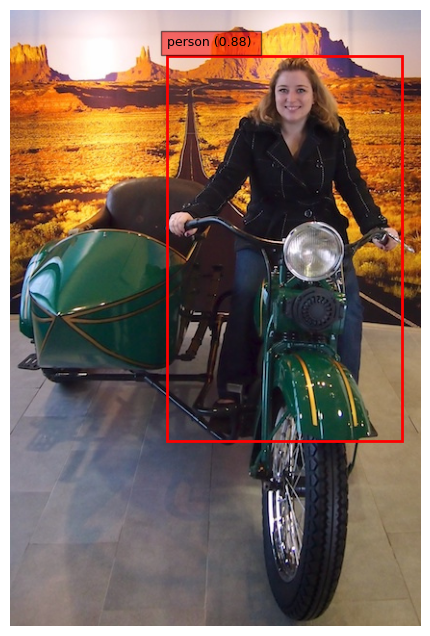

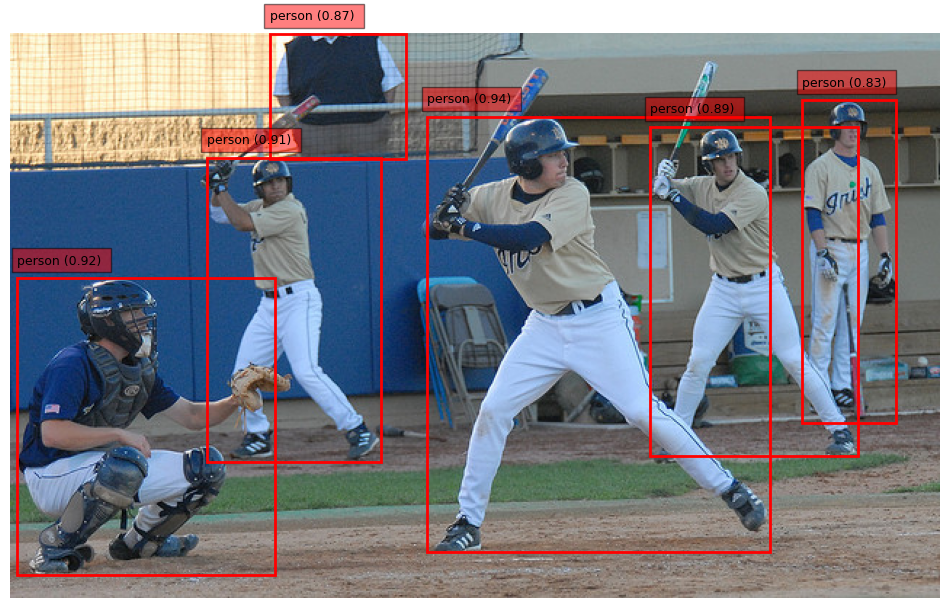

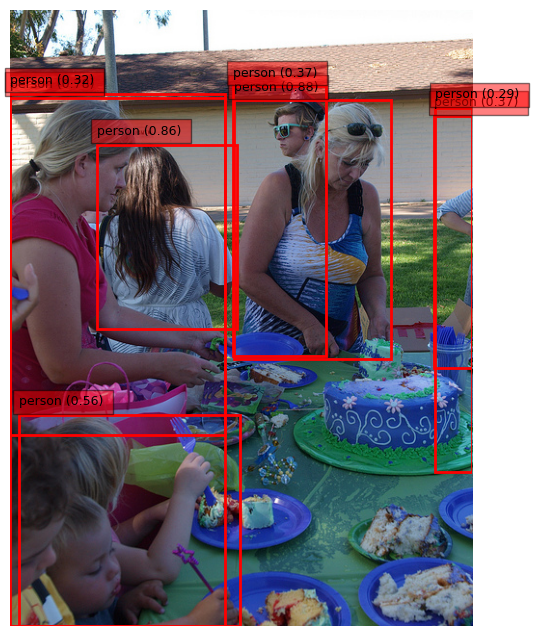

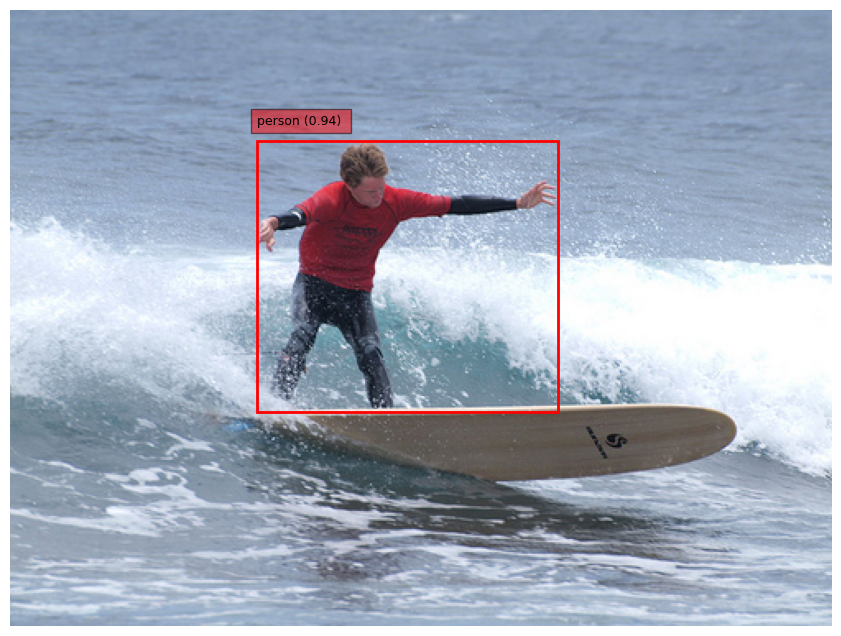

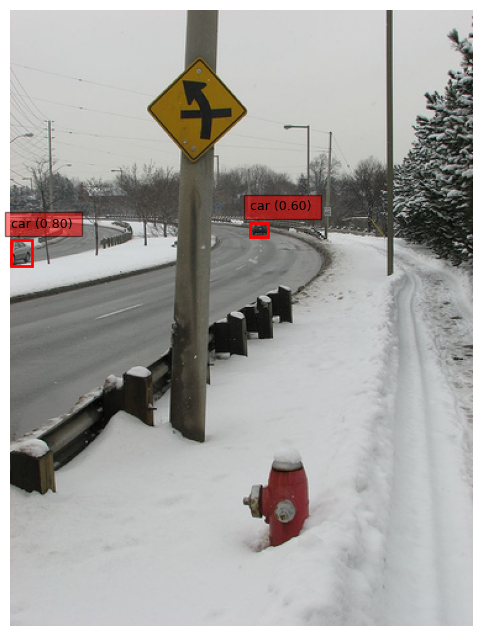

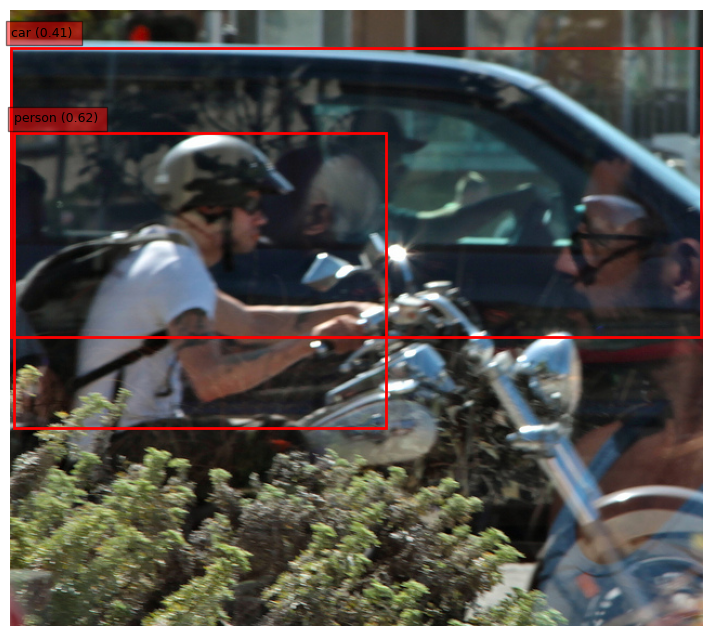

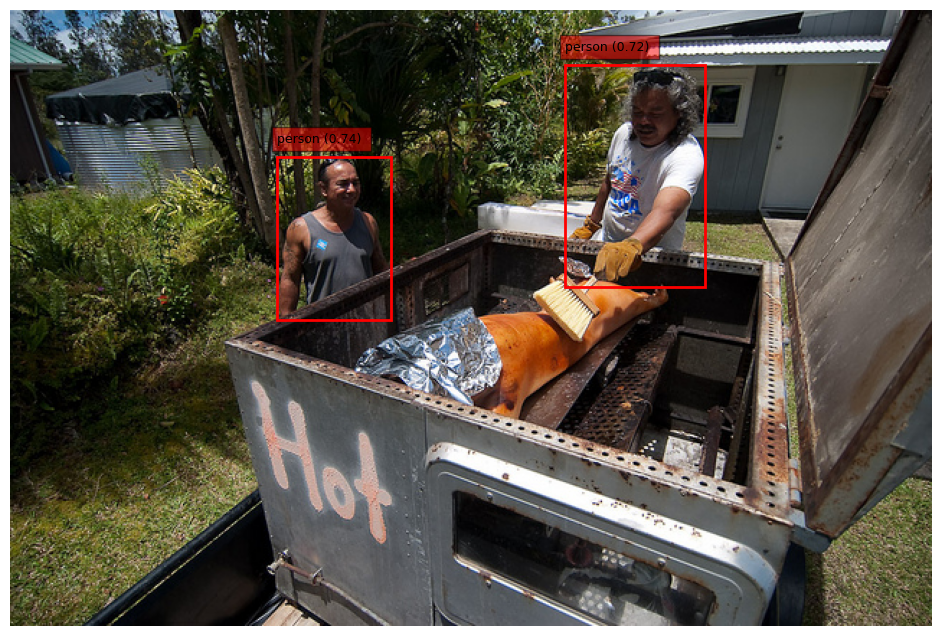

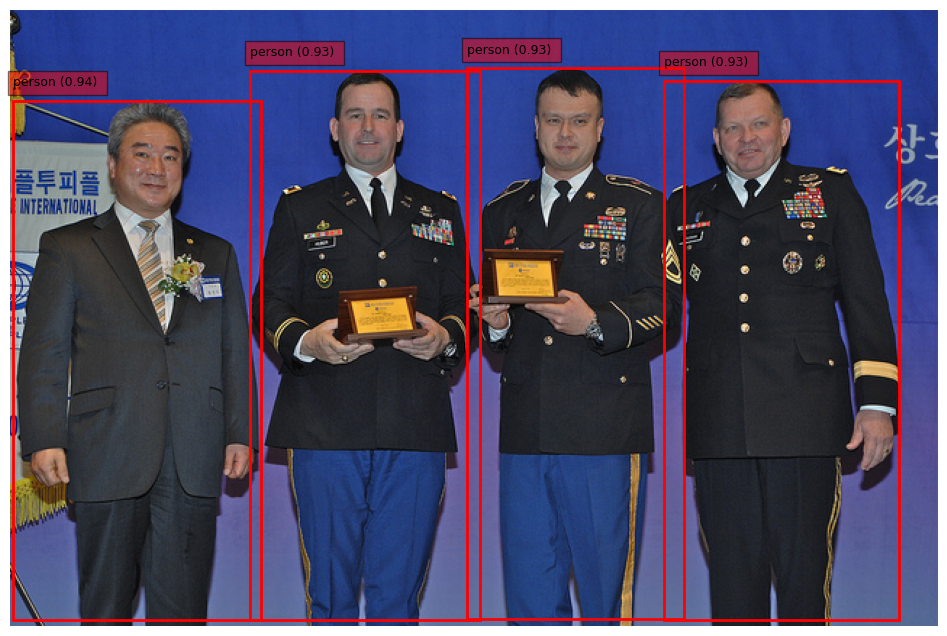

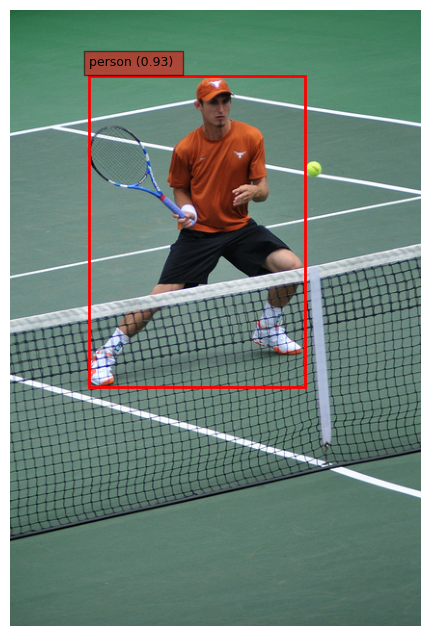

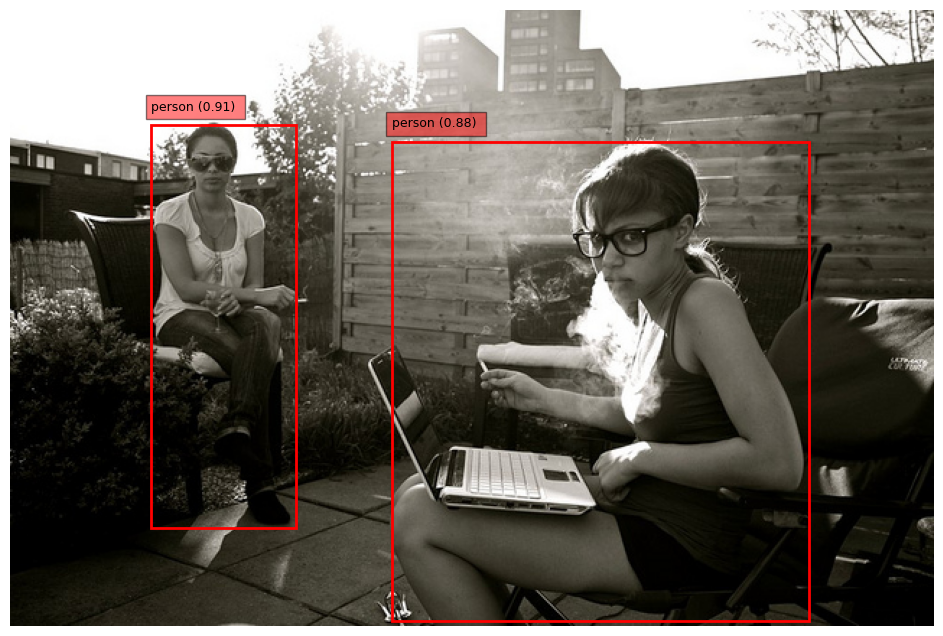

In [15]:
import torch
det_model_path = 'models/yolov11/detect/train/weights/best.pt'
yolo = YOLO(det_model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def detection(img_path, det_model):

    '''
        Get all information with object in the image
        Params:
            img_path: path of the image want to detect
            det_model: model detection yolov11

        Returns:
            Tuple include bboxes, classes, names, confs
    '''
    det_results = det_model(img_path, verbose=False)[0]

    bboxes = det_results.boxes.xyxy.tolist()
    classes = det_results.boxes.cls.tolist()
    names = det_results.names
    confs = det_results.boxes.conf.tolist()

    return bboxes, classes, names, confs

import matplotlib.pyplot as plt

def visualize_detections(img, detections):

    '''
        Visualize all bounding box with class name and confident score

        Params:
            img: image want to draw bboxes
            detections: informations about bboxes, class name , confident score
    '''
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')

    for bbox, detected_class, confidence in detections:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(x1, y1 - 10, f"{detected_class} ({confidence:.2f}) ", fontsize=9, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

from PIL import Image

def predict(img_path, det_model, device):

    '''
          To plot image was add bbox

          Params:
              img_path: path of the image to plot
              det_model: model detection (yolov11)
              device: 'cpu' or 'cuda'
          Returns:
              List of predictions include [bboxes, class name , confident score]

    '''

    bboxes, classes, names, confs = detection(img_path, det_model)


    img = Image.open(img_path)

    predictions = []


    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        predictions.append((bbox, name, confidence))


    visualize_detections(img, predictions)

    return predictions

img_dir = '/content/yolo_data/val/images'

for img_filename in os.listdir(img_dir)[:10]:
    img_path = os.path.join(img_dir, img_filename)
    predictions = predict(
        img_path,
        det_model=yolo,
        device=device
    )